### points to take care of now onwards
1. Add PCA components
1. Search how to make the NN deeper
1. Get it on the GPU
1. Plot training losses with the validation losses
1. **use KFold CV**

# usual imports

In [1]:
import os
import pandas as pd
import numpy as np
import gc

import matplotlib.pyplot as plt
from scipy import stats# Imports
import torch

import torchvision
import torch.nn as nn

import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset, random_split

In [2]:
gc.collect()

21

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ubiquant-market-prediction/example_sample_submission.csv
/kaggle/input/ubiquant-market-prediction/example_test.csv
/kaggle/input/ubiquant-market-prediction/train.csv
/kaggle/input/ubiquant-market-prediction/ubiquant/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/ubiquant-market-prediction/ubiquant/__init__.py
/kaggle/input/ubiquant-market-prediction-half-precision-pickle/train.pkl


## Import dataset

In [4]:
n_features = 300
features = [f'f_{i}' for i in range(n_features)]
train = pd.read_pickle('../input/ubiquant-market-prediction-half-precision-pickle/train.pkl')
train.head(2)

,investment_id,time_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,target
0,1,0,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,0.965820,1.230469,...,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533,-0.300781
1,2,0,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,1.427734,1.133789,...,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506,-0.231079


In [5]:
inputs = train.drop(['target'], axis=1).values
targets = train[['target']].values

inputs.shape, targets.shape

((3141410, 302), (3141410, 1))

### 80 % split number - just for splitting

In [6]:
val_1 = int(0.8*inputs.shape[0])
val_2 = int(0.2*inputs.shape[0])
val_1, val_2

(2513128, 628282)

### Hyperparameters

In [7]:
batch_size = 2000
TARGET_COLUMN = 'target'
input_size=302
output_size=1

In [8]:
del train
gc.collect()

63

# Convert to PyTorch dataset (DataLoader)

In [9]:
dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))
train_ds, val_ds = random_split(dataset, [val_1, val_2])

train_loader = DataLoader(train_ds, batch_size, shuffle=False) # future predict karna hai na
val_loader = DataLoader(val_ds, batch_size*2)

In [10]:
del train_ds, val_ds, dataset, inputs, targets
gc.collect()

42

## GPU Utilities
#### these will help later to get our models/dataloaders on the GPU!

In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

#### Check if GPU is avaliable

In [12]:
torch.cuda.is_available()

True

In [13]:
device = get_default_device()
device

device(type='cuda')

### "Push" to the GPU

In [14]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(train_loader, device)

# This is the heart of the Neural Network!
**feel free to edit the layers anytime**

A lot of credit for this goes to 
1. Akash N S, for his Jovian.ai Course. This notebook specially makes use of functions from here https://jovian.ai/aakashns-6l3/deep-learning-project-live
1. @Pytonash's Recent notebook using Keras, and a very similar structure - End to end simple and powerful DNN with LeakyReLU - https://www.kaggle.com/pythonash/end-to-end-simple-and-powerful-dnn-with-leakyrelu
3. General answers from StackOverflow like this one, which helps to make out where should features be placed and ordered https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout

In [15]:
class My_Kaggle_Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Activation functions have been chosen either as SiLU (called as Swish in Keras), and LeakyReLU
        # I have used them in alternate, please comment if this is a good practice or not!
        self.layers = nn.Sequential(nn.Linear(input_size, 64), 
                                    nn.BatchNorm1d(64), 
                                    nn.SiLU(), 
                                    
                                    nn.Linear(64, 128), 
                                    nn.BatchNorm1d(128), 
                                    # nn.LeakyReLU(0.1), 
                                    nn.SiLU(),
                                    nn.Dropout(0.4),
                                    
                                    nn.Linear(128, 256), 
                                    nn.BatchNorm1d(256), 
                                    nn.SiLU(), 
                                    nn.Dropout(0.4),
                                    
                                    nn.Linear(256, 512), 
                                    nn.BatchNorm1d(512), 
                                    # nn.LeakyReLU(0.1),
                                    nn.SiLU(),
                                    nn.Dropout(0.4), 
                                    
                                    nn.Linear(512, 256), 
                                    nn.BatchNorm1d(256), 
                                    nn.SiLU(),
                                    nn.Dropout(0.4),
                                    
                                    nn.Linear(256, 128), 
                                    nn.BatchNorm1d(128), 
                                    # nn.LeakyReLU(0.1),
                                    nn.SiLU(),
                                    nn.Dropout(0.4),
                                    
                                    nn.Linear(128, 8), 
                                    nn.BatchNorm1d(8), 
                                    nn.SiLU(), 
                                    nn.Dropout(0.4),
                                    
                                    nn.Linear(8, 1) )
    
        
    def forward(self, x):
        return self.layers(x)
    
    def training_step(self, batch):
        torch.cuda.empty_cache()
        gc.collect()
        inputs, targets = batch 
        inputs.to(device)
        targets.to(device)
        
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        return loss
    
    def validation_step(self, batch):
        torch.cuda.empty_cache()
        gc.collect()
        inputs, targets = batch 
        inputs.to(device)
        targets.to(device)
        
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['train_loss'], result['val_loss']))
    
model = My_Kaggle_Model()

In [16]:
# shift model to GPU
model = to_device(model, device)

### Simple functions for evaluating and fitting

In [17]:
def evaluate(model, val_loader):
    model.eval()  # Setting to eval mode makes sure that dropouts are 'frozen'
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train() # Setting to train mode
        train_losses = []
        
        for (i,batch) in enumerate(train_loader):
            torch.cuda.empty_cache()
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            if (i%200 == 0): print('batch number -- ', i)
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        
#         # Early Stopping
#         if (result['valid_loss'][epoch] > result['valid_loss'][epoch - 1]) & (epoch >0):
#             trigger_times += 1
#             print('trigger times ', trigger_times)
            
#             if trigger_times >= patience:
#                 print('Early stopping!\nStart to test process.')
#                 return model
#         else:
#             print('trigger times: 0')
#             trigger_times = 0
            
    return history

### Checking if everything is on the GPU

In [18]:
train_loader.device, val_loader.device

(device(type='cuda'), device(type='cuda'))

In [19]:
type(model)

__main__.My_Kaggle_Model

In [20]:
model.state_dict()['layers.0.weight']

tensor([[-0.0450, -0.0543,  0.0315,  ..., -0.0190, -0.0150,  0.0005],
        [ 0.0494,  0.0416, -0.0041,  ..., -0.0243, -0.0446, -0.0407],
        [-0.0487, -0.0179,  0.0028,  ..., -0.0072,  0.0504, -0.0491],
        ...,
        [-0.0339,  0.0208, -0.0226,  ...,  0.0098,  0.0115, -0.0399],
        [ 0.0134,  0.0431, -0.0346,  ..., -0.0427,  0.0519,  0.0390],
        [-0.0512,  0.0464,  0.0565,  ..., -0.0246, -0.0021, -0.0568]],
       device='cuda:0')

*observe how the weights are also on the GPU, so nice to see!*

# Train!

In [21]:
learning_rate = 1e-1

In [22]:
gc.collect()

147

In [23]:
history = fit(10, learning_rate, model, train_loader, val_loader, opt_func=torch.optim.Adam)

batch number --  0
batch number --  200
batch number --  400
batch number --  600
batch number --  800
batch number --  1000
batch number --  1200
Epoch [0], train_loss: 0.8441, val_loss: 0.8521
batch number --  0
batch number --  200
batch number --  400
batch number --  600
batch number --  800
batch number --  1000
batch number --  1200
Epoch [1], train_loss: 0.8361, val_loss: 0.8391
batch number --  0
batch number --  200
batch number --  400
batch number --  600
batch number --  800
batch number --  1000
batch number --  1200
Epoch [2], train_loss: 0.8349, val_loss: 0.8434
batch number --  0
batch number --  200
batch number --  400
batch number --  600
batch number --  800
batch number --  1000
batch number --  1200
Epoch [3], train_loss: 0.8346, val_loss: 0.8323
batch number --  0
batch number --  200
batch number --  400
batch number --  600
batch number --  800
batch number --  1000
batch number --  1200
Epoch [4], train_loss: 0.8343, val_loss: 0.8360
batch number --  0
batch 

In [24]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
history

[{'val_loss': 0.8521440029144287, 'train_loss': 0.8441387414932251},
 {'val_loss': 0.8390878438949585, 'train_loss': 0.8361467719078064},
 {'val_loss': 0.8434250354766846, 'train_loss': 0.8349288702011108},
 {'val_loss': 0.8322630524635315, 'train_loss': 0.8345692753791809},
 {'val_loss': 0.8360334634780884, 'train_loss': 0.8343096971511841},
 {'val_loss': 0.8320338726043701, 'train_loss': 0.8336008787155151},
 {'val_loss': 0.8304229378700256, 'train_loss': 0.8337907195091248},
 {'val_loss': 0.837978184223175, 'train_loss': 0.8333766460418701},
 {'val_loss': 0.8299148678779602, 'train_loss': 0.832933247089386},
 {'val_loss': 0.8339259028434753, 'train_loss': 0.8323901891708374}]

In [25]:
# !/opt/bin/nvidia-smi
# optional function to check if you have a GPU or not

In [26]:
# train for more with lower learning rate
history2 = fit(10, 5e-3, model, train_loader, val_loader, opt_func=torch.optim.Adam)

batch number --  0
batch number --  200
batch number --  400
batch number --  600
batch number --  800
batch number --  1000
batch number --  1200
Epoch [0], train_loss: 0.8284, val_loss: 0.8256
batch number --  0
batch number --  200
batch number --  400
batch number --  600
batch number --  800
batch number --  1000
batch number --  1200
Epoch [1], train_loss: 0.8279, val_loss: 0.8256
batch number --  0
batch number --  200
batch number --  400
batch number --  600
batch number --  800
batch number --  1000
batch number --  1200
Epoch [2], train_loss: 0.8277, val_loss: 0.8254
batch number --  0
batch number --  200
batch number --  400
batch number --  600
batch number --  800
batch number --  1000
batch number --  1200
Epoch [3], train_loss: 0.8275, val_loss: 0.8252
batch number --  0
batch number --  200
batch number --  400
batch number --  600
batch number --  800
batch number --  1000
batch number --  1200
Epoch [4], train_loss: 0.8274, val_loss: 0.8250
batch number --  0
batch 

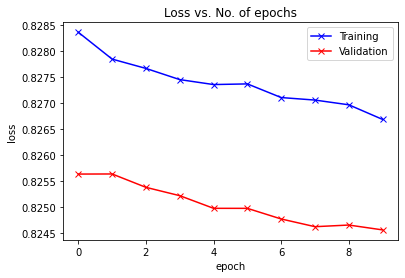

In [27]:
plot_losses(history2)

**it is a good practice to check this curve and determine if our model is overfitting or not**

In [28]:
# train for more with lower learning rate
history3 = fit(10, 5e-5, model, train_loader, val_loader, opt_func=torch.optim.Adam)

batch number --  0
batch number --  200
batch number --  400
batch number --  600
batch number --  800
batch number --  1000
batch number --  1200
Epoch [0], train_loss: 0.8264, val_loss: 0.8239
batch number --  0
batch number --  200
batch number --  400
batch number --  600
batch number --  800
batch number --  1000
batch number --  1200
Epoch [1], train_loss: 0.8264, val_loss: 0.8238
batch number --  0
batch number --  200
batch number --  400
batch number --  600
batch number --  800
batch number --  1000
batch number --  1200
Epoch [2], train_loss: 0.8261, val_loss: 0.8238
batch number --  0
batch number --  200
batch number --  400
batch number --  600
batch number --  800
batch number --  1000
batch number --  1200
Epoch [3], train_loss: 0.8263, val_loss: 0.8238
batch number --  0
batch number --  200
batch number --  400
batch number --  600
batch number --  800
batch number --  1000
batch number --  1200
Epoch [4], train_loss: 0.8263, val_loss: 0.8238
batch number --  0
batch 

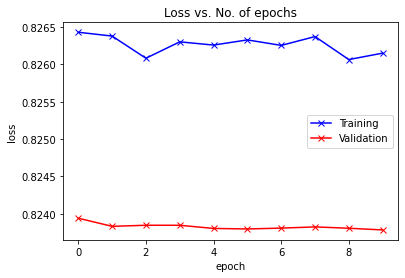

In [29]:
plot_losses(history3)

### Record results

In [30]:
history3[-1]

{'val_loss': 0.8237826228141785, 'train_loss': 0.8261511921882629}

In [31]:
# evaluate(model, train_loader), evaluate(model, val_loader)

### important to save the model!

In [32]:
torch.save(model.state_dict(), 'my_trained_model.pth')

# time to make predictions!

In [33]:
# val_ds[1][0].shape, val_ds[1][1].shape

### Simple function to predict

In [34]:
torch.cuda.empty_cache() # just to clear some GPU cache memory

#### lets see if it works on the train loader (it should!)

In [35]:
for batch in train_loader:
    model.eval() # not strictly necessary to put it in eval mode, because we took adequate care earlier
    data, target = batch
    print('data.shape', data.shape)
    print('data.device', data.device)
    preds = model(data)
    print('preds.shape', preds.shape)
    break # this is just for checking, so I break after one round

data.shape torch.Size([2000, 302])
data.device cuda:0
preds.shape torch.Size([2000, 1])


#### and on the valid loader

In [36]:
for batch in val_loader:
    model.eval()
    data, target = batch
    print('data.shape', data.shape)
    print('data.device', data.device)
    preds = model(data)
    print('preds.shape', preds.shape)
    break

data.shape torch.Size([2000, 302])
data.device cuda:0
preds.shape torch.Size([2000, 1])


In [37]:
preds[:5], target[:5]

(tensor([[-0.0146],
         [-0.0839],
         [-0.1641],
         [ 0.0394],
         [ 0.0972]], device='cuda:0', grad_fn=<SliceBackward>),
 tensor([[-0.8711],
         [ 0.2462],
         [-0.2064],
         [-1.5498],
         [ 0.4731]], device='cuda:0'))

In [38]:
gc.collect()

3257

# Submission Time!

### simple function to predict on the test dataframe

In [39]:
cols_order = ['investment_id' , 'time_id'] + features

In [40]:
def predict_for_test_data(test_data):
    test_ds = TensorDataset(torch.tensor(test_data.values, dtype=torch.float32))
    submission_try = []
    
    for x in test_ds:
        model.eval()
        input_x = x[0].unsqueeze(0).cuda()
        pred = model(input_x)
        submission_try.append(pred)
        print("Prediction:", pred)
        
    submission_values = [float(i.detach()) for i in submission_try]
    return submission_values

In [41]:
# test_df

In [42]:
# predict_for_test_data(test_df)

### submit off!
Credits to @Melanie7744 for informing about the submission API. Here is the link to her work https://www.kaggle.com/melanie7744/understanding-the-submission-api-for-newbies

In [43]:
import ubiquant
env = ubiquant.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test set and sample submission
for (test_df, sample_prediction_df) in iter_test:
    
    print("test_df as loaded by the API")
    display(test_df.head(), test_df.shape)
    #display(sample_prediction_df.head(), sample_prediction_df.shape)
    
    # here you need to modify test_df to match the training data
    test_df['time_id'] = test_df.row_id.str.split("_", expand=True)[0].astype("int16") #re-create time_id
    test_df = test_df[cols_order]  
    print("test_df after selecting/creating the features the model was trained with")
    display(test_df.head(), test_df.shape)
    
    # Call our function to make predictions
    predictions = predict_for_test_data(test_df)
    sample_prediction_df['target'] = predictions  # make your predictions here
    env.predict(sample_prediction_df)   # register your predictions
    
    # print("Predictions for this time_id")
    # display(sample_prediction_df)
    # print("-----------time_id finished-----------\n\n")

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
test_df as loaded by the API


,row_id,investment_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,1220_1,1,0.874944,0.457875,0.962572,0.372061,0.004509,0.971304,0.097477,0.246080,...,0.514031,0.828523,0.437697,0.810764,0.693963,0.186403,0.569144,0.120386,0.419603,0.936966
1,1220_2,2,0.554862,0.445478,0.714034,0.891988,0.703331,0.264478,0.600636,0.697096,...,0.620919,0.301540,0.687464,0.400168,0.908198,0.272901,0.222430,0.748324,0.858802,0.362829


(2, 302)

test_df after selecting/creating the features the model was trained with


,investment_id,time_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,1,1220,0.874944,0.457875,0.962572,0.372061,0.004509,0.971304,0.097477,0.246080,...,0.514031,0.828523,0.437697,0.810764,0.693963,0.186403,0.569144,0.120386,0.419603,0.936966
1,2,1220,0.554862,0.445478,0.714034,0.891988,0.703331,0.264478,0.600636,0.697096,...,0.620919,0.301540,0.687464,0.400168,0.908198,0.272901,0.222430,0.748324,0.858802,0.362829


(2, 302)

Prediction: tensor([[-0.0876]], device='cuda:0', grad_fn=<AddmmBackward>)
Prediction: tensor([[0.0177]], device='cuda:0', grad_fn=<AddmmBackward>)
test_df as loaded by the API


,row_id,investment_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,1221_0,0,0.175070,0.918464,0.044379,0.505868,0.037160,0.169001,0.211365,0.791252,...,0.397710,0.789382,0.238078,0.254068,0.795084,0.491928,0.376725,0.079489,0.995041,0.482283
1,1221_1,1,0.355239,0.689773,0.452643,0.134863,0.794958,0.837197,0.036773,0.713466,...,0.893571,0.322879,0.674692,0.114160,0.818483,0.287065,0.710537,0.550434,0.899869,0.928997
2,1221_2,2,0.912778,0.462684,0.454067,0.491009,0.050547,0.250051,0.686295,0.666958,...,0.031662,0.703427,0.861476,0.897927,0.659051,0.356148,0.375990,0.209798,0.175153,0.727160


(3, 302)

test_df after selecting/creating the features the model was trained with


,investment_id,time_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0,1221,0.175070,0.918464,0.044379,0.505868,0.037160,0.169001,0.211365,0.791252,...,0.397710,0.789382,0.238078,0.254068,0.795084,0.491928,0.376725,0.079489,0.995041,0.482283
1,1,1221,0.355239,0.689773,0.452643,0.134863,0.794958,0.837197,0.036773,0.713466,...,0.893571,0.322879,0.674692,0.114160,0.818483,0.287065,0.710537,0.550434,0.899869,0.928997
2,2,1221,0.912778,0.462684,0.454067,0.491009,0.050547,0.250051,0.686295,0.666958,...,0.031662,0.703427,0.861476,0.897927,0.659051,0.356148,0.375990,0.209798,0.175153,0.727160


(3, 302)

Prediction: tensor([[-0.0269]], device='cuda:0', grad_fn=<AddmmBackward>)
Prediction: tensor([[-0.0382]], device='cuda:0', grad_fn=<AddmmBackward>)
Prediction: tensor([[-0.0423]], device='cuda:0', grad_fn=<AddmmBackward>)
test_df as loaded by the API


,row_id,investment_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,1222_0,0,0.678116,0.158996,0.058148,0.253677,0.984982,0.323493,0.307990,0.683907,...,0.439604,0.487491,0.080697,0.539750,0.246645,0.435054,0.436709,0.315042,0.133657,0.731483
1,1222_1,1,0.769912,0.060028,0.676047,0.853550,0.411155,0.747515,0.649063,0.628536,...,0.419152,0.659254,0.198072,0.655397,0.428209,0.769999,0.960219,0.734675,0.028576,0.320976
2,1222_2,2,0.738876,0.980038,0.696796,0.591012,0.882052,0.311484,0.729229,0.516416,...,0.341144,0.758328,0.010728,0.276859,0.979913,0.486605,0.670140,0.515824,0.580929,0.139308


(3, 302)

test_df after selecting/creating the features the model was trained with


,investment_id,time_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0,1222,0.678116,0.158996,0.058148,0.253677,0.984982,0.323493,0.307990,0.683907,...,0.439604,0.487491,0.080697,0.539750,0.246645,0.435054,0.436709,0.315042,0.133657,0.731483
1,1,1222,0.769912,0.060028,0.676047,0.853550,0.411155,0.747515,0.649063,0.628536,...,0.419152,0.659254,0.198072,0.655397,0.428209,0.769999,0.960219,0.734675,0.028576,0.320976
2,2,1222,0.738876,0.980038,0.696796,0.591012,0.882052,0.311484,0.729229,0.516416,...,0.341144,0.758328,0.010728,0.276859,0.979913,0.486605,0.670140,0.515824,0.580929,0.139308


(3, 302)

Prediction: tensor([[-0.0146]], device='cuda:0', grad_fn=<AddmmBackward>)
Prediction: tensor([[0.0082]], device='cuda:0', grad_fn=<AddmmBackward>)
Prediction: tensor([[-0.0804]], device='cuda:0', grad_fn=<AddmmBackward>)
test_df as loaded by the API


,row_id,investment_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,1223_0,0,0.281445,0.571472,0.986828,0.021403,0.789577,0.005765,0.409379,0.952,...,0.357828,0.000019,0.50453,0.169174,0.216349,0.503643,0.052721,0.795965,0.909602,0.291668


(1, 302)

test_df after selecting/creating the features the model was trained with


,investment_id,time_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0,1223,0.281445,0.571472,0.986828,0.021403,0.789577,0.005765,0.409379,0.952,...,0.357828,0.000019,0.50453,0.169174,0.216349,0.503643,0.052721,0.795965,0.909602,0.291668


(1, 302)

Prediction: tensor([[-0.0038]], device='cuda:0', grad_fn=<AddmmBackward>)
